In [37]:
import numpy as np

In [38]:
from tqdm import tqdm as tqdm

In [39]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
def blr(y, F, mu_0, Sigma_0, a_0, b_0, n_draws=1):
    n = y.shape[0]
    p = mu_0.shape[0]
    mu_post = np.matmul(np.linalg.inv(np.matmul(np.transpose(F), F) + Sigma_0),
                        np.matmul(Sigma_0, mu_0) + np.matmul(np.transpose(F), y))
    Sigma_post = np.matmul(np.transpose(F), F) + Sigma_0
    a_post = a_0 + n / 2
    b_post = b_0 + 0.5 * (np.matmul(np.transpose(y), y) + 
                          np.matmul(np.matmul(np.transpose(mu_0), Sigma_0), mu_0) - 
                          np.matmul(np.matmul(np.transpose(mu_post), Sigma_post), mu_post))
    beta = np.empty([n_draws, p])
    sigma2_eps = 1 / np.random.gamma(a_post, 1 / b_post, n_draws)
    
    for i in range(n_draws):
        beta[i, :] = np.random.multivariate_normal(mu_post, sigma2_eps[i] * np.linalg.inv(Sigma_post))
    return beta, sigma2_eps


def blr_mv(y, F, mu_0, Sigma_0, a_0, b_0):
    q = y.shape[1]
    r = F.shape[1]
    beta_est = np.empty([r, q])
    sigma2_eps_est = np.empty(q)
    for j in range(q):
        results = blr(y[:, j], F, mu_0, Sigma_0, a_0, b_0)
        beta_est[:, j] = results[0]
        sigma2_eps_est[j] = results[1]
    return beta_est, sigma2_eps_est


def sample_regression_posterior(Y, F, loading_prior_params=[0, 1], variance_prior_params=[1, 1]):
    r = F.shape[1]
    mu_0 = np.repeat(loading_prior_params[0], r)  # prior for regression coefficients
    Sigma_0 = np.diag(np.repeat(loading_prior_params[1], r)) 
    loading, variance = blr_mv(Y, F, mu_0, Sigma_0, variance_prior_params[0], variance_prior_params[1])
    return loading, variance

In [41]:
from scipy.stats import gamma, cauchy, multivariate_normal, norm

In [42]:
def l_gamma_prior(l, a, b):
    """
    Gamma prior on length scale
    """
    return gamma.pdf(l, a=a, scale=1/b)


def s_half_cauchy_prior(s, scale):
    return 2 * cauchy.pdf(s, loc=0, scale=scale)


def kernel_covariance(x, l, s, noise=1e-6):
    """
    Covariance matrix with squared exponential kernel
    """
    t = x.shape[0]
    cov_sample = np.zeros((t, t))
    for i in range(t):
        for j in range(t):
            cov_sample[i, j] = s ** 2 * np.exp(-(x[i] - x[j]) ** 2 / (2 * l ** 2))
    cov_sample += np.eye(t) * noise  # add noise for numerical stability
    return cov_sample


def reshape_latent_curves(F, n, t):
    """
    Turn latent factors F of shape [nt, r] into a list of r factors of shape [t, n]
    """
    r = F.shape[1]
    F_curves_list = []
    for j in range(r):
        F_curves = np.zeros((t, n))
        for i in range(n):
            F_curves[:, i] = F[(i * t):(i * t + t), j]
        F_curves_list.append(F_curves)
    return F_curves_list

In [43]:
def accept_reject(accept_prob):
    u = np.random.uniform(low=0.0, high=1.0, size=1)
    return u < accept_prob


def gp_marginal_likelihood(y, x, l, s):
    """
    Marginal likelihood of one Gaussian process (multivariate Normal)
    """
    t = y.shape[0]
    mu = np.repeat(0, t)
    cov = kernel_covariance(x, l, s)
    return multivariate_normal.pdf(y, mu, cov)


def propose(current, std):
    value = -1
    while value < 0:
        value = np.random.normal(loc=current, scale=std, size=1)
    return value


def calculate_p(l, s, Y, x, prior_params):
    a, b, scale = prior_params
    prior = l_gamma_prior(l, a, b)  # * s_half_cauchy_prior(s, scale)
    t, n = Y.shape
    cov = kernel_covariance(x, l, s)
    inverse = np.linalg.inv(cov)
    loglik = 0.0
    sign, logdet = np.linalg.slogdet(cov)
    constant = -0.5 * logdet - 0.5 * t * np.log(2 * np.pi)
    for j in range(Y.shape[1]):
        loglik += -0.5 * np.matmul(np.matmul(Y[:, j].reshape((1, t)), inverse), Y[:, j].reshape((t, 1)))[0][0] + constant
    return loglik + np.log(prior)


def metropolis_update(l, s, p, Y, x, prior_params, proposal_scales):
    l_new = propose(l, proposal_scales[0])
    s_new = 1.0

    p_new = calculate_p(l_new, s_new, Y, x, prior_params)
    
    if accept_reject(np.exp(p_new - p)):
        return l_new, s_new, p_new
    else:
        return l, s, p


def metropolis_sample(n_iter, Y, x, prior_params, proposal_scales):
    # initial length scale proposal is centered at Gamma prior mean
    l = propose(prior_params[0] * prior_params[1], proposal_scales[0])
    s = 1.0
    p = calculate_p(l, s, Y, x, prior_params)
    
    l_trace = []
    s_trace = []
    for i in range(n_iter):
        l, s, p = metropolis_update(l, s, p, Y, x, prior_params, proposal_scales)
        l_trace.append(l)
        s_trace.append(s)
        
    return l_trace, s_trace

In [44]:
def build_covariance_blocks(F_covariance_list, loading_matrix, Y_variance):
    """
    Build covariance matrix for long vector of all columns of Y stacked together.
    
    Args
        F_covariance_list: (list) of [t, t] covariance matrices
        loading_matrix: (numpy array) [r, q] linear transformation between F and Y
        Y_sigma_list: (numpy array) [q] variance parameters for columns of Y
    """
    r = len(F_covariance_list)
    t = F_covariance_list[0].shape[0]
    q = loading_matrix.shape[1]
    block_YY = np.zeros((q * t, q * t))
    # covariance for columns of F
    block_FF_rows = []
    for i in range(r):
        current_row = np.zeros((t, r * t))
        current_row[:, (i * t):(i * t + t)] = F_covariance_list[i]
        block_FF_rows.append(current_row)
    block_FF = np.vstack(block_FF_rows)
    # covariance between columns of F and columns of Y
    block_FY_rows = []
    for i in range(r):
        current_row = np.zeros((t, q * t))
        for j in range(q):
            current_row[:, (j * t):(j * t + t)] = loading_matrix[i, j] * F_covariance_list[i]
        block_FY_rows.append(current_row)
    block_FY = np.vstack(block_FY_rows)
    block_YF = np.transpose(block_FY)
    # covariance between columns of Y
    block_YY_rows = []
    for i in range(q):
        current_row = np.zeros((t, q * t))
        for j in range(q):
            for k in range(r):
                current_row[:, (j * t):(j * t + t)] += F_covariance_list[k] * loading_matrix[k, i] * loading_matrix[k, j]
            if i == j:
                current_row[:, (j * t):(j * t + t)] += np.eye(t) * Y_variance[i]  # diagonal variance
        block_YY_rows.append(current_row)
    block_YY = np.vstack(block_YY_rows)
    return block_FF, block_FY, block_YF, block_YY

In [45]:
def sample_conditional_F(Y, blocks, debug=False):
    """
    Sample from conditional distribution of F given everything else.
    
    Args
        Y: (numpy array) [t, q] observed multivariate time series
        block_FF, block_FY, block_YF, block_YY: (numpy array) blocks in the covariance of joint distribution
    """
    block_FF, block_FY, block_YF, block_YY = blocks
    t, q = Y.shape
    r = int(block_FF.shape[0] / t)
    Y_stack = np.transpose(Y).reshape(t * q)  # stack columns of Y
    block_YY_inverse = np.linalg.inv(block_YY)
    F_stack = np.zeros(t * r)
    for i in range(r):
        prod = np.matmul(block_FY[(i * t):(i * t + t), :], block_YY_inverse)
        mu = np.matmul(prod, Y_stack)
        covariance = block_FF[(i * t):(i * t + t), :][:, (i * t):(i * t + t)] - \
        np.matmul(prod, block_YF[:, (i * t):(i * t + t)])
        F_stack[(i * t):(i * t + t)] = np.random.multivariate_normal(mu, covariance)
    F_sample = np.transpose(F_stack.reshape((r, t)))  # de-stack columns of F
    if debug:
        return F_sample, covariance
    else:
        return F_sample

In [46]:
def sample_conditional_F(Y, F_covariance_list, loading_matrix, Y_variance):
    """
    Sample from conditional distribution of F given everything else.
    
    Args
        Y: (numpy array) [t, q] observed multivariate time series
        block_FF, block_FY, block_YF, block_YY: (numpy array) blocks in the covariance of joint distribution
    """
    block_FF, block_FY, block_YF, block_YY = build_covariance_blocks(F_covariance_list, loading_matrix, Y_variance)
    t, q = Y.shape
    r = int(block_FF.shape[0] / t)
    Y_stack = np.transpose(Y).reshape(t * q)  # stack columns of Y
    block_YY_inverse = np.linalg.inv(block_YY)
    F_stack = np.zeros(t * r)
    for i in range(r):
        prod = np.matmul(block_FY[(i * t):(i * t + t), :], block_YY_inverse)
        mu = np.matmul(prod, Y_stack)
        covariance = block_FF[(i * t):(i * t + t), :][:, (i * t):(i * t + t)] - \
        np.matmul(prod, block_YF[:, (i * t):(i * t + t)])
        F_stack[(i * t):(i * t + t)] = np.random.multivariate_normal(mu, covariance)
    F_sample = np.transpose(F_stack.reshape((r, t)))  # de-stack columns of F
    if debug:
        return F_sample, covariance
    else:
        return F_sample

In [47]:
def new_conditional_F(Y, F_covariance_list, loading_matrix, Y_variance):
    r = len(F_covariance_list)
    t, q = Y.shape
    Y_stack = np.transpose(Y).reshape(t * q)  # stack columns of Y
    residuals = Y_stack.copy()
    F_stack = np.zeros(t * r)
    for i in range(r):
        block_FF, block_FY, block_YF, block_YY = factor_covariance_blocks(F_covariance_list, loading_matrix, Y_variance, i)
        block_YY_inverse = np.linalg.inv(block_YY)
        prod = np.matmul(block_FY, block_YY_inverse)
        mu = np.matmul(prod, residuals)
        covariance = block_FF - np.matmul(prod, block_YF)
        conditional = np.random.multivariate_normal(mu, covariance)
        F_stack[(i * t):(i * t + t)] = conditional
        hat = np.matmul(conditional.reshape((t, 1)), loading_matrix[i, :].reshape((1, q)))
        residuals = residuals - np.transpose(hat).reshape(t * q)
    F_sample = np.transpose(F_stack.reshape((r, t)))  # de-stack columns of F
    return F_sample

In [48]:
def factor_covariance_blocks(F_covariance_list, loading_matrix, Y_variance, factor_index):
    """
    Build covariance matrix for long vector of all columns of Y stacked together.
    
    Args
        F_covariance_list: (list) of [t, t] covariance matrices
        loading_matrix: (numpy array) [r, q] linear transformation between F and Y
        Y_sigma_list: (numpy array) [q] variance parameters for columns of Y
    """
    r = len(F_covariance_list)
    t = F_covariance_list[0].shape[0]
    q = loading_matrix.shape[1]
    block_YY = np.zeros((q * t, q * t))
    # covariance for columns of F
    block_FF = F_covariance_list[factor_index]
    # covariance between columns of F and columns of Y
    block_FY_rows = []
    current_row = np.zeros((t, q * t))
    for j in range(q):
        current_row[:, (j * t):(j * t + t)] = loading_matrix[factor_index, j] * F_covariance_list[factor_index]
    block_FY = current_row
    block_YF = np.transpose(block_FY)
    # covariance between columns of Y
    block_YY_rows = []
    for i in range(q):
        current_row = np.zeros((t, q * t))
        for j in range(q):
            current_row[:, (j * t):(j * t + t)] += F_covariance_list[factor_index] \
            * loading_matrix[factor_index, i] * loading_matrix[factor_index, j]
            if i == j:
                current_row[:, (j * t):(j * t + t)] += np.eye(t) * Y_variance[i]  # diagonal variance
        block_YY_rows.append(current_row)
    block_YY = np.vstack(block_YY_rows)
    return block_FF, block_FY, block_YF, block_YY

In [49]:
def conditional_F_dist(F_covariance_list, loading_matrix, Y_variance):
    block_FF, block_FY, block_YF, block_YY = build_covariance_blocks(F_covariance_list, loading_matrix, Y_variance)
    block_YY_inverse = np.linalg.inv(block_YY)
    prod = np.matmul(block_FY, block_YY_inverse)
    covariance = block_FF - np.matmul(prod, block_YF)
    return prod, covariance


def sample_conditonal_F_dist(Y, prod, covariance):
    t, q = Y.shape
    r = int(covariance.shape[0] / t)
    Y_stack = np.transpose(Y).reshape(t * q)  # stack columns of Y
    mu = np.matmul(prod, Y_stack)
    F_stack = np.random.multivariate_normal(mu, covariance)
    F_sample = np.transpose(F_stack.reshape((r, t)))  # de-stack columns of F
    return F_sample

In [50]:
class FactorGP:
    """
    Latent factor Gaussian process model for multivariate time series
    Data: n epochs, t time points, q dimensional, r latent factors
    Parameters: loading matrix (r x q), variance vector (q), length scale (r)
    Priors: Conjugate Normal, inverse-Gamma, and Gamma (needs to be informative)
    """

    def __init__(self, dims, mu_var=[0, 1], inverse_gamma=[1, 1], gamma=[10, 1], F=None):
        n, t, q, r = dims
        self.dims = dims
        self.x = np.linspace(1, t, t)  # time points are indexed by intergers from 1 to t
        self.loading_prior_params = mu_var  # prior mean and variance for loading coeffcients
        self.variance_prior_params = inverse_gamma  # inverse Gamma prior for variance
        self.length_prior_params = gamma  # Gamma prior on length scale
        # self.kernel_type = 'default'
        self.loading, self.variance, self.theta = self.__initiate_params(dims, mu_var, inverse_gamma, gamma)
        self.F = F

    def __initiate_params(self, dims, mu_var, inverse_gamma, gamma):
        n, t, q, r = dims
        loading = np.random.normal(mu_var[0], np.sqrt(mu_var[1]), [r, q])
        variance = np.random.normal(0, 0.5, q) ** 2  # TODO: implement inverse-Gamma prior
        theta = np.repeat(gamma[0] * gamma[1], r)  # set length scale to gamma mean
        return loading, variance, theta

    def conditional_latent(self, Y):
        n, t, q, r = self.dims
        covs = []
        for l in self.theta:
            covs.append(kernel_covariance(self.x, l, 1.0))
        prod, covariance = conditional_F_dist(covs, self.loading, self.variance)
        F = np.zeros((n * t, r))
        for i in range(n):  # sample from F conditional distribution for each epoch independently
            F[(i * t):(i * t + t), :] = sample_conditonal_F_dist(Y[(i * t):(i * t + t), :], prod, covariance)
        self.F = F

    def predict(self):
        return np.matmul(self.F, self.loading)

In [51]:
def gibbs_update_params(Y, model, chain_size=50, proposal_std=0.5):
    """
    Sample from model parameter posterior given Y and F 
    
    Note: the model does not change at all
    """
    n, t, q, r = model.dims
    if model.F is None:
        model.conditional_latent(Y)
    F = model.F  # get current latent and condition on it for sampling
    loading, variance = sample_regression_posterior(Y, F, model.loading_prior_params, model.variance_prior_params)
    theta = np.zeros(r)
    traces = np.zeros((r, chain_size))
    F_curves_list = reshape_latent_curves(F, n, t)
    for i, F_curves in enumerate(F_curves_list):
        l_trace, s_trace = metropolis_sample(chain_size, F_curves, model.x, 
                                             prior_params=[model.length_prior_params[0], model.length_prior_params[1], 1.0], 
                                             proposal_scales=[proposal_std, proposal_std])
        theta[i] = l_trace[-1]
        traces[i, :] = l_trace
    return F, loading, variance, theta, traces

In [82]:
def run_gibbs(Y, model, n_steps, chain_size, proposal_std, verbose=False):
    """
    Run Metropolis with-in Gibbs sampler on latent factor GP model using data Y
    
    Args
        Y: (numpy array) of shape [nt, q] and contains n stacked epochs of [t, q]
        model: latent factor GP model
        n_steps: (int) number of steps
        chain_size: (int) size of Metropolis chain at each iteration
        proposal_std: (float) standard deviation of Metropolis proposal distribution
        verbose: (bool) whether or not to print out MSE and length scale (for sanity check)
    """
    n, t, q, r = model.dims
    
    F_sample = np.zeros((n_steps, n * t, r))
    loading_sample = np.zeros((n_steps, r, q))
    variance_sample = np.zeros((n_steps, q))
    theta_sample = np.zeros((n_steps, r))
    traces_hist = np.zeros((n_steps, r, chain_size))
    mse_history = np.zeros(n_steps)
    
    for i in tqdm(range(n_steps)):
        F, loading, variance, theta, traces = gibbs_update_params(Y, model, chain_size, proposal_std)
        # update model parameters and predict
        model.loading = loading
        model.variance = variance
        model.theta = theta
        Y_hat = model.predict()
        mse = np.mean((Y - Y_hat) ** 2)
        if verbose:
            print('Current MSE: {}'.format(mse))
            print('Current length scale: {}'.format(theta))
        # save everything
        F_sample[i, :, :] = F
        loading_sample[i, :, :] = loading 
        variance_sample[i, :] = variance
        theta_sample[i, :] = theta
        traces_hist[i, :, :] = traces
        mse_history[i] = mse
        # update model latent factors
        model.conditional_latent(Y)
    return F_sample, loading_sample, variance_sample, theta_sample, traces_hist, mse_history

In [53]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

In [54]:
gp = GaussianProcessRegressor(kernel=RBF(length_scale=10))

In [108]:
x = np.linspace(1, 50, 50)
curves = gp.sample_y(x.reshape((50, 1)), 10)

In [109]:
F = curves

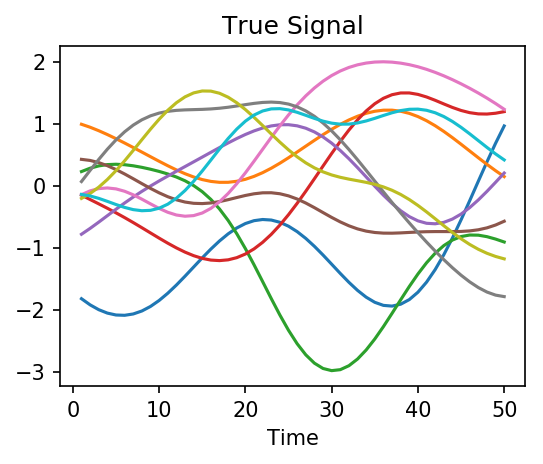

In [110]:
fig = plt.figure(figsize=(4, 3), dpi=150)
for j in range(10):
    plt.plot(x, F[:, j])
plt.title('True Signal')
plt.xlabel('Time')
plt.show()

In [111]:
loading = np.random.normal(0, 1, [10, 50])
Y_true = np.matmul(F, loading)

In [123]:
t, q = Y_true.shape
n = 100
Y = np.zeros((n * t, q))
for i in range(n):
    Y[(i * t):(i * t + t), :] = Y_true + np.random.normal(0, 0.5, [50, 50])

In [124]:
print(Y.shape)

(5000, 50)


In [125]:
dims = [n, 50, 50, 10]  # n, t, q, r
model = FactorGP(dims)

In [117]:
import time

In [126]:
start = time.time()
model.conditional_latent(Y)
end = time.time()
print(end - start)

11.3643629551


In [128]:
results = run_gibbs(Y, model, 10, 100, 0.5, verbose=True)




  0%|          | 0/10 [00:00<?, ?it/s]/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: overflow encountered in exp


Current MSE: 0.24860615421
Current length scale: [8.44641435 9.47706016 9.69128804 9.52277694 8.47961055 7.11487548
 8.54443973 7.4934719  8.95838666 8.6408844 ]





 10%|█         | 1/10 [00:30<04:32, 30.31s/it]

Current MSE: 0.248238460374
Current length scale: [8.48015088 9.52396022 9.8858605  9.57115633 8.54817113 7.2339407
 8.67448414 7.57862124 8.90962029 8.60463401]





 20%|██        | 2/10 [01:02<04:06, 30.80s/it]

Current MSE: 0.248771428818
Current length scale: [ 8.50777124  9.54167582 10.05090424  9.57675908  8.56955344  7.3278483
  8.82949665  7.72017058  9.07339832  8.6465651 ]





 30%|███       | 3/10 [01:33<03:37, 31.04s/it]

Current MSE: 0.248619217141
Current length scale: [ 8.55699885  9.49527945 10.03914624  9.65739775  8.69000872  7.44317318
  8.92461644  7.7933534   9.19982089  8.59803446]





 40%|████      | 4/10 [02:03<03:03, 30.63s/it]

Current MSE: 0.248872339784
Current length scale: [ 8.64877625  9.57683508 10.09852058  9.62466588  8.7698343   7.62832668
  9.08529738  7.92475055  9.28735166  8.70242591]





 50%|█████     | 5/10 [02:37<02:38, 31.61s/it]

Current MSE: 0.249051716784
Current length scale: [ 8.75529362  9.67013522 10.16962171  9.64352827  8.77802822  7.72824546
  9.16282216  7.99795516  9.32995637  8.78303749]





 60%|██████    | 6/10 [03:13<02:11, 32.85s/it]

Current MSE: 0.249239246796
Current length scale: [ 8.83444524  9.67297239 10.23411118  9.62976325  8.75764354  7.81741591
  9.37345611  8.04437545  9.34954606  8.9106245 ]





 70%|███████   | 7/10 [03:49<01:42, 34.04s/it]

Current MSE: 0.249444693078
Current length scale: [ 8.95632023  9.61751901 10.27746638  9.72600506  8.82148042  7.8714407
  9.51489295  8.21290264  9.45616594  8.99844585]





 80%|████████  | 8/10 [04:30<01:11, 35.91s/it]

Current MSE: 0.249519189291
Current length scale: [ 9.07073251  9.63691785 10.22531091  9.91269377  8.82553023  7.96637765
  9.58999148  8.35885123  9.56159521  9.00528575]





 90%|█████████ | 9/10 [05:14<00:38, 38.28s/it]

KeyboardInterrupt: 

In [32]:
F_sample, loading_sample, variance_sample, theta_sample, traces_hist, mse_history = results

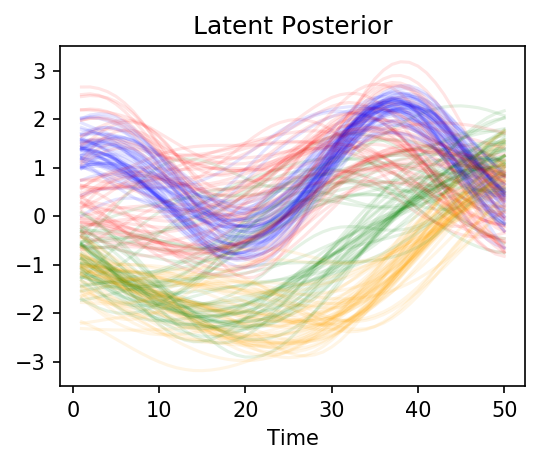

In [33]:
fig = plt.figure(figsize=(4, 3), dpi=150)
for i in range(50, 100):
    plt.plot(x, F_sample[i, :50, 0], color='orange', alpha=0.1)
    plt.plot(x, F_sample[i, :50, 1], color='blue', alpha=0.1)
    plt.plot(x, F_sample[i, :50, 2], color='green', alpha=0.1)
    plt.plot(x, F_sample[i, :50, 3], color='red', alpha=0.1)
plt.title('Latent Posterior')
plt.xlabel('Time')
plt.show()

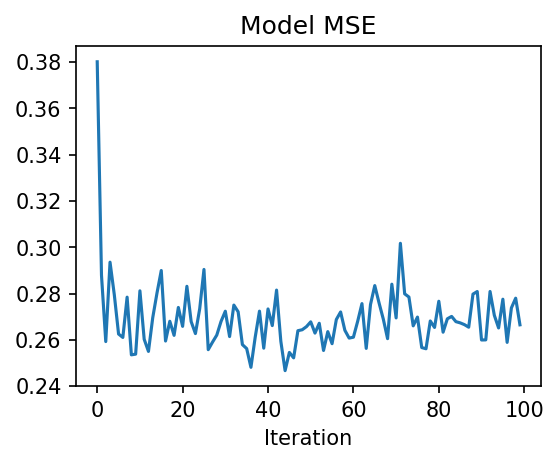

In [34]:
fig = plt.figure(figsize=(4, 3), dpi=150)
plt.plot(mse_history)
plt.title('Model MSE')
plt.xlabel('Iteration')
plt.show()

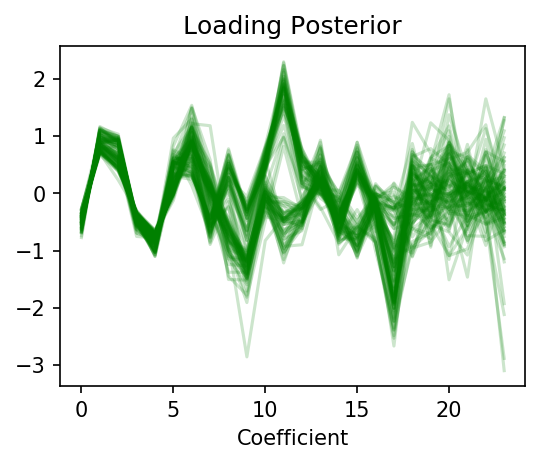

In [85]:
fig = plt.figure(figsize=(4, 3), dpi=150)
for i in range(100):
    plt.plot(loading_sample[i].flatten(), alpha=0.2, color='green')
plt.title('Loading Posterior')
plt.xlabel('Coefficient')
plt.show()

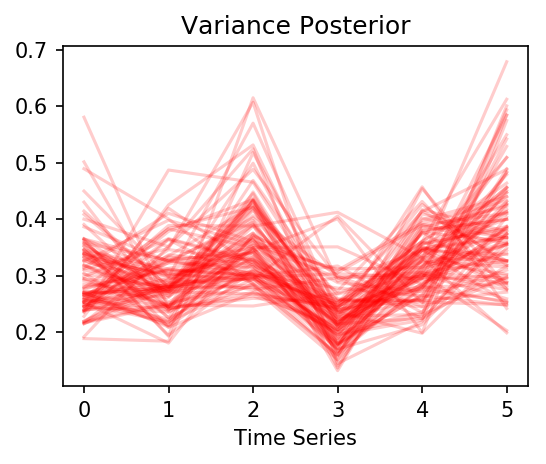

In [86]:
fig = plt.figure(figsize=(4, 3), dpi=150)
for i in range(100):
    plt.plot(variance_sample[i], alpha=0.2, color='red')
plt.title('Variance Posterior')
plt.xlabel('Time Series')
plt.show()

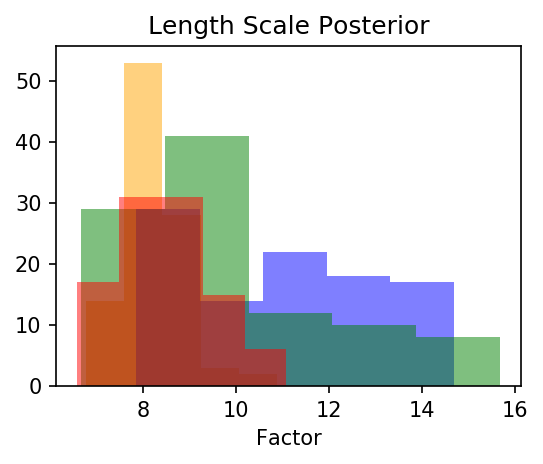

In [87]:
fig = plt.figure(figsize=(4, 3), dpi=150)
plt.hist(theta_sample[:, 0], bins=5, alpha=0.5, color='orange')
plt.hist(theta_sample[:, 1], bins=5, alpha=0.5, color='blue')
plt.hist(theta_sample[:, 2], bins=5, alpha=0.5, color='green')
plt.hist(theta_sample[:, 3], bins=5, alpha=0.5, color='red')
plt.title('Length Scale Posterior')
plt.xlabel('Factor')
plt.show()

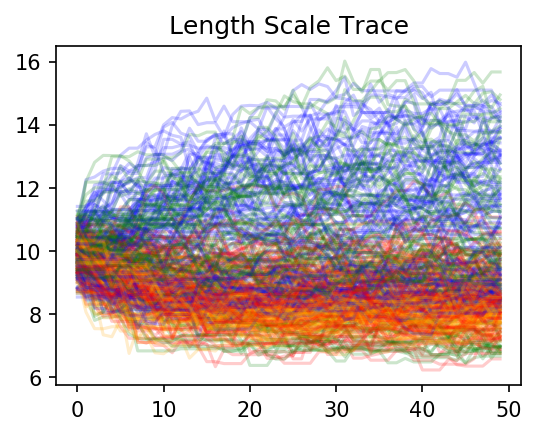

In [88]:
fig = plt.figure(figsize=(4, 3), dpi=150)
for i in range(100):
    plt.plot(traces_hist[i, 0, :], alpha=0.2, color='orange')
    plt.plot(traces_hist[i, 1, :], alpha=0.2, color='blue')
    plt.plot(traces_hist[i, 2, :], alpha=0.2, color='green')
    plt.plot(traces_hist[i, 3, :], alpha=0.2, color='red')
plt.title('Length Scale Trace')
plt.show()